In [1]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/BME548L/archive.zip' -d '/content/kaggle'

Streaming output truncated to the last 5000 lines.
  inflating: /content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: /content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: /content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: /content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: /content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: /content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: /content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: /content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: /content/kaggl

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_10_mask.tif
/content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_10.tif
/content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_16.tif
/content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_20_mask.tif
/content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_18.tif
/content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_19.tif
/content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_8_mask.tif
/content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5.tif
/content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_11_mask.tif
/content/kaggle/lgg-mri-segmentation/kaggle_3m/TC

In [3]:
!pip install monai -q

     |████████████████████████████████| 721 kB 7.6 MB/s 


In [4]:
import os
import numpy as np 
import pandas as pd 

import monai
import torch,torchvision

import random
import cv2
import skimage
from skimage import io

from glob import glob
import matplotlib.pyplot as plt
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection
from monai.data import Dataset, ArrayDataset, create_test_image_3d, DataLoader
from monai.transforms import (
    Compose,
    AddChanneld,
    LoadImaged,
    Spacingd,
    Resized,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
    ToTensor,
    ToTensord,
    Orientationd,
    NormalizeIntensityd,
    RandRotated,
    RandAxisFlipd,
    RandFlipd,
    AdjustContrastd,
)

In [5]:
print_config()

MONAI version: 0.8.1
Numpy version: 1.21.6
Pytorch version: 1.11.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.12.0+cu113
tqdm version: 4.64.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [6]:
data = pd.read_csv('/content/kaggle/lgg-mri-segmentation/kaggle_3m/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [7]:
data.head(10)

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   
5  TCGA_CS_5395            2.0                 4.0             2        2.0   
6  TCGA_CS_5396            3.0                 3.0             2        3.0   
7  TCGA_CS_5397            NaN                 4.0             1        2.0   
8  TCGA_CS_6186            2.0                 4.0             1        2.0   
9  TCGA_CS_6188            2.0                 4.0             3        2.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   
5          NaN              3.0           2                3.0   
6          2.0              2.0           3                3.0   
7          3.0              3.0           2                1.0   
8          1.0              3.0           2                2.0   
9          3.0              3.0           2                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   
5                        1.0                1.0         3.0             5.0   
6                        2.0                1.0         3.0             2.0   
7                        2.0                1.0         1.0             6.0   
8                        2.0                1.0         3.0             2.0   
9                        2.0                1.0         3.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0  
5     2.0                       43.0   2.0        NaN      1.0  
6     1.0                       53.0   3.0        2.0      0.0  
7     1.0                       54.0   3.0        2.0      1.0  
8     2.0                       58.0   3.0        2.0      1.0  
9     2.0                       48.0   3.0        2.0      0.0

In [8]:
data_map = []
for sub_dir_path in glob("/content/kaggle/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        if os.path.isdir(sub_dir_path):
            dir_name = sub_dir_path.split('/')[-1]
            for filename in os.listdir(sub_dir_path):
                image_path = sub_dir_path + '/' + filename
                data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

In [9]:
data = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
data.head()

patient_id                                               path
0  TCGA_DU_A5TW_19980228  /content/kaggle/lgg-mri-segmentation/kaggle_3m...
1  TCGA_DU_A5TW_19980228  /content/kaggle/lgg-mri-segmentation/kaggle_3m...
2  TCGA_DU_A5TW_19980228  /content/kaggle/lgg-mri-segmentation/kaggle_3m...
3  TCGA_DU_A5TW_19980228  /content/kaggle/lgg-mri-segmentation/kaggle_3m...
4  TCGA_DU_A5TW_19980228  /content/kaggle/lgg-mri-segmentation/kaggle_3m...

In [10]:
data_imgs = data[~data['path'].str.contains("mask")]
data_masks = data[data['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89
END_IMG_LEN = 4
END_MASK_LEN = 9

# Data sorting
imgs = sorted(data_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(data_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_11.tif 
Path to the Mask: /content/kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_11_mask.tif


In [11]:
# Final dataframe
brain_data = pd.DataFrame({"patient_id": data_imgs.patient_id.values,
                             "image_path": imgs,
                             "mask_path": masks
                            })

def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_data['mask'] = brain_data['mask_path'].apply(lambda x: pos_neg_diagnosis(x))

In [12]:
brain_data.head()

patient_id                                         image_path  \
0  TCGA_DU_A5TW_19980228  /content/kaggle/lgg-mri-segmentation/kaggle_3m...   
1  TCGA_DU_A5TW_19980228  /content/kaggle/lgg-mri-segmentation/kaggle_3m...   
2  TCGA_DU_A5TW_19980228  /content/kaggle/lgg-mri-segmentation/kaggle_3m...   
3  TCGA_DU_A5TW_19980228  /content/kaggle/lgg-mri-segmentation/kaggle_3m...   
4  TCGA_DU_A5TW_19980228  /content/kaggle/lgg-mri-segmentation/kaggle_3m...   

                                           mask_path  mask  
0  /content/kaggle/lgg-mri-segmentation/kaggle_3m...     0  
1  /content/kaggle/lgg-mri-segmentation/kaggle_3m...     0  
2  /content/kaggle/lgg-mri-segmentation/kaggle_3m...     0  
3  /content/kaggle/lgg-mri-segmentation/kaggle_3m...     0  
4  /content/kaggle/lgg-mri-segmentation/kaggle_3m...     0

In [13]:
brain_data['mask'].value_counts().values

array([2556, 1373])

In [14]:
brain_data['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [15]:
mask_imgs_idx = []
for i in range(len(brain_data)):
    if cv2.imread(brain_data.mask_path[i]).max() > 0:
        mask_imgs_idx.append(i)

In [16]:
i = random.choice(mask_imgs_idx)
print(i)

1430


In [17]:
cv2.imread(brain_data.mask_path[i]).max(), cv2.imread(brain_data.mask_path[i]).min()

(255, 0)

In [18]:
from PIL import Image
import requests
from io import BytesIO

img = Image.open(brain_data.image_path[i])
sample = np.array(img)

In [19]:
sample.shape

(256, 256, 3)

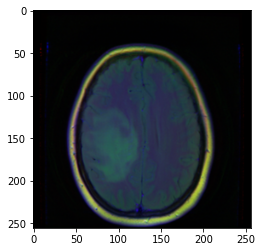

In [20]:
import skimage.io
import matplotlib.pyplot as plt
import skimage.filters

image = skimage.io.imread(brain_data.image_path[i])
fig, ax = plt.subplots()
plt.imshow(image)
plt.show()


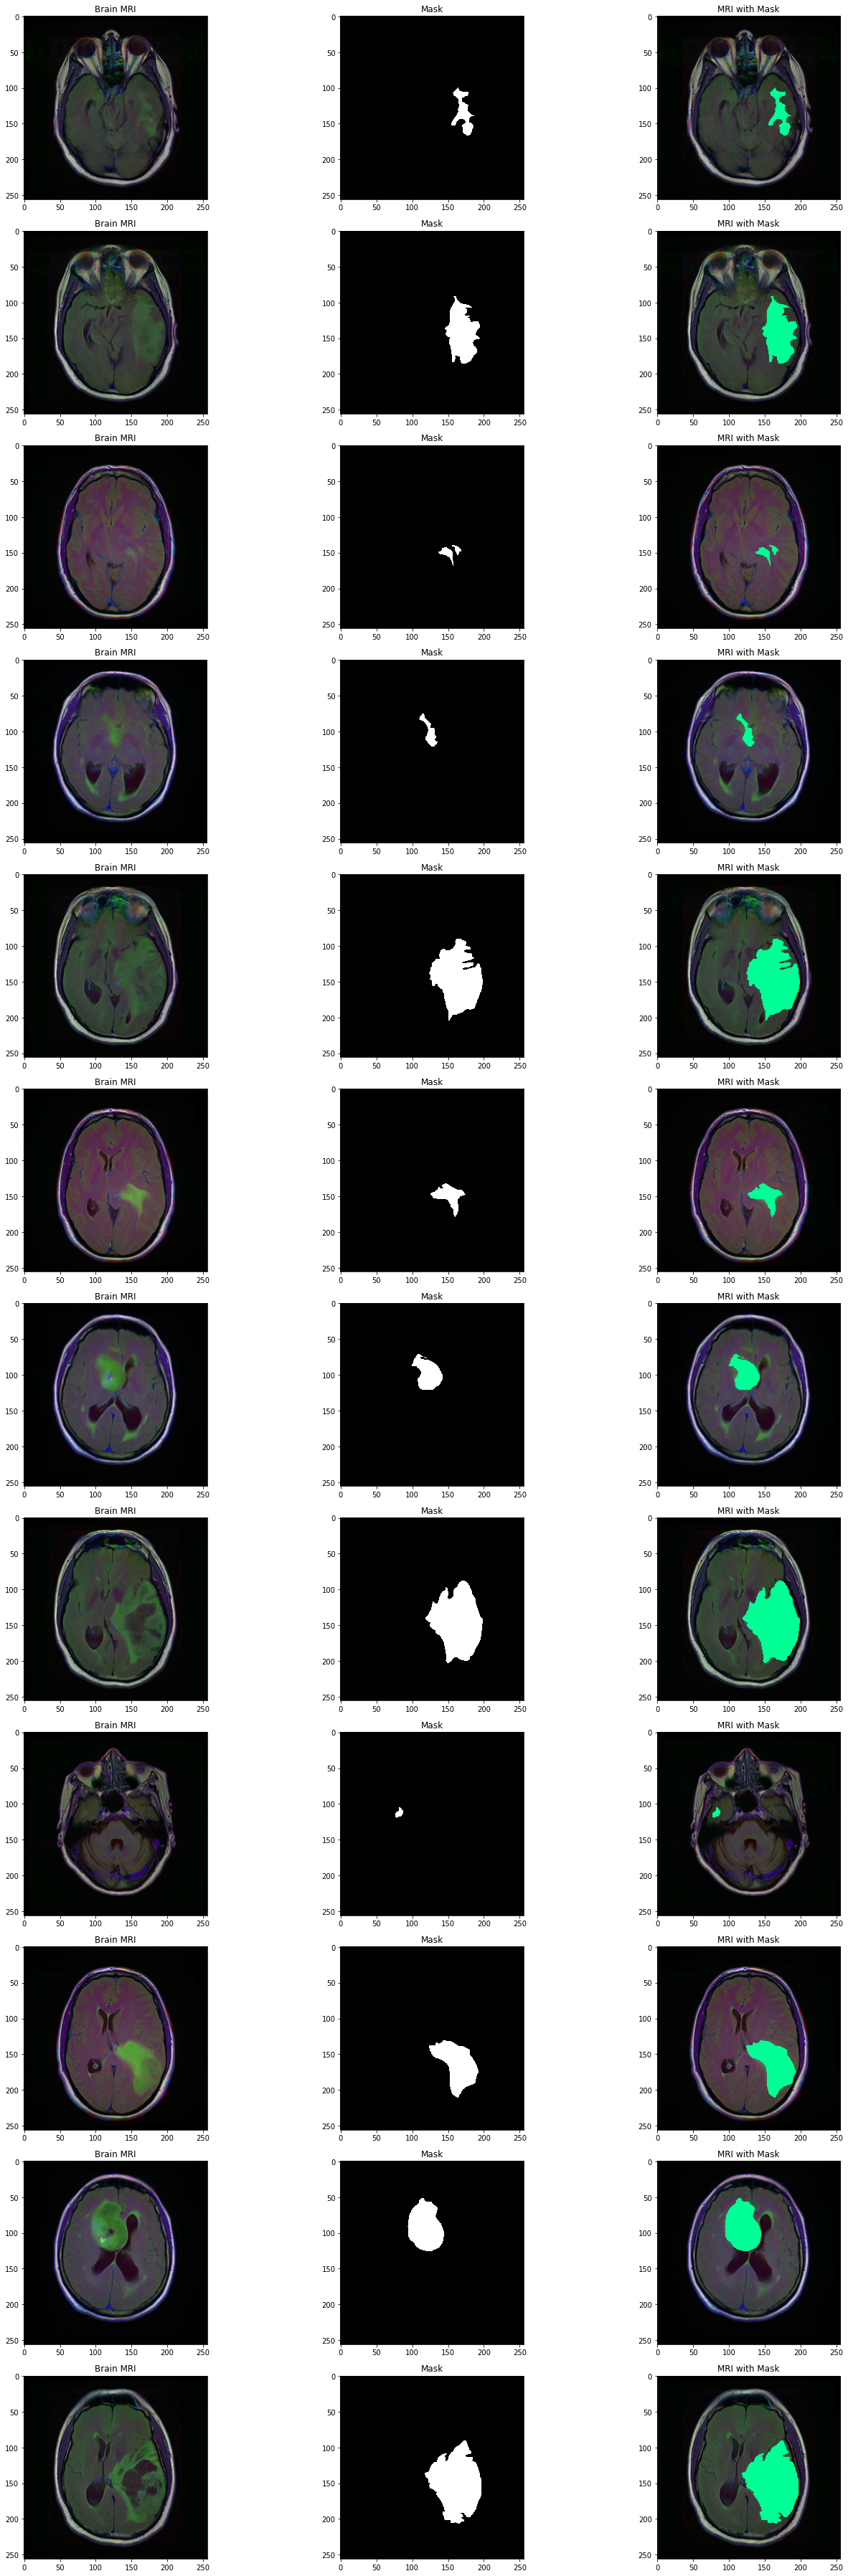

In [21]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))

# sigma = 3.0
# def gaussian_blur(image, sigma, truncate = 3.5, multichannel=True):
#     blurred = skimage.filters.gaussian(
#         image, sigma=(sigma, sigma), truncate=3.5, multichannel=True)
#     return blurred

for i in mask_imgs_idx:
#     if (mask==1):
    
    img = io.imread(brain_data.image_path[i])
    # img = gaussian_blur(img, sigma)

    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    mask = io.imread(brain_data.mask_path[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap='gray')

    img[mask==255] = (0,255,150)  # change pixel color at the position of mask
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img)
    count +=1
    i += 1
    if (count==12):
        break
        
fig.tight_layout()

In [22]:
# Creating Dir to store the converted files
dir = '/content/output/'
mask_out_path = '/content/output/mask'
input_out_path = '/content/output/input'
os.mkdir(dir)
os.mkdir(mask_out_path)
os.mkdir(input_out_path)

In [23]:
# This library will help in convention
!pip install imio -q

In [24]:
from imio import load, save

In [25]:
# Traning Files
for i in mask_imgs_idx:
    path = brain_data['image_path'].iloc[i]
    img = plt.imread(path)
    # img = gaussian_blur(img, sigma)
    img = skimage.color.rgb2gray(img)
    name = os.path.basename(os.path.normpath(path))
    name = os.path.splitext(name)[0]
    save.to_nii(img, "{}/{}.nii.gz".format(input_out_path,name))

In [26]:
# Mask Files
for i in mask_imgs_idx:
    path = brain_data['mask_path'].iloc[i]
    img = plt.imread(path)
    name = os.path.basename(os.path.normpath(path))
    name = os.path.splitext(name)[0]
    save.to_nii(img, "{}/{}.nii.gz".format(mask_out_path,name))

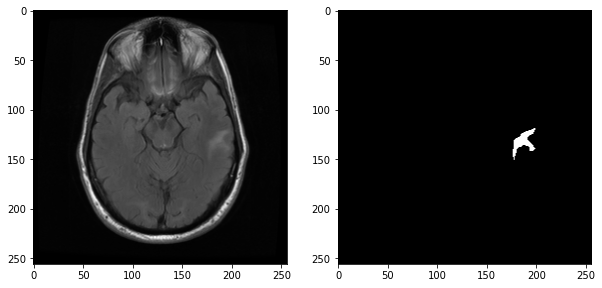

In [27]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
i = random.choice(mask_imgs_idx)
img = skimage.color.rgb2gray(plt.imread(brain_data['image_path'].iloc[i]))
mask = plt.imread(brain_data['mask_path'].iloc[i])
ax[0].imshow(img,cmap='gray')
ax[1].imshow(mask,cmap='gray')

In [28]:
brain_data.head()

patient_id                                         image_path  \
0  TCGA_DU_A5TW_19980228  /content/kaggle/lgg-mri-segmentation/kaggle_3m...   
1  TCGA_DU_A5TW_19980228  /content/kaggle/lgg-mri-segmentation/kaggle_3m...   
2  TCGA_DU_A5TW_19980228  /content/kaggle/lgg-mri-segmentation/kaggle_3m...   
3  TCGA_DU_A5TW_19980228  /content/kaggle/lgg-mri-segmentation/kaggle_3m...   
4  TCGA_DU_A5TW_19980228  /content/kaggle/lgg-mri-segmentation/kaggle_3m...   

                                           mask_path  mask  
0  /content/kaggle/lgg-mri-segmentation/kaggle_3m...     0  
1  /content/kaggle/lgg-mri-segmentation/kaggle_3m...     0  
2  /content/kaggle/lgg-mri-segmentation/kaggle_3m...     0  
3  /content/kaggle/lgg-mri-segmentation/kaggle_3m...     0  
4  /content/kaggle/lgg-mri-segmentation/kaggle_3m...     0

In [29]:
# First we have to get that .nii data
filenames = []
img = sorted(glob('/content/output/input/*'))
mask = sorted(glob('/content/output/mask/*'))
for i in range(len(img)):
    filenames.append({'img':img[i],'mask':mask[i]})

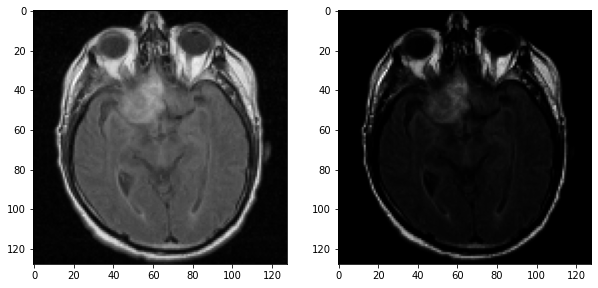

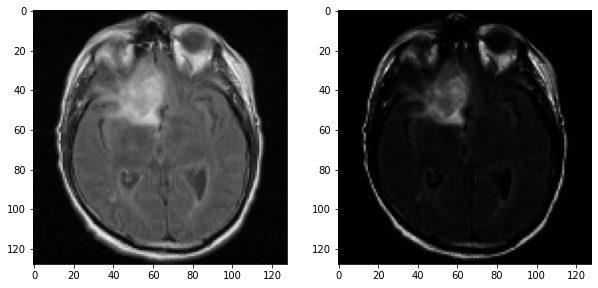

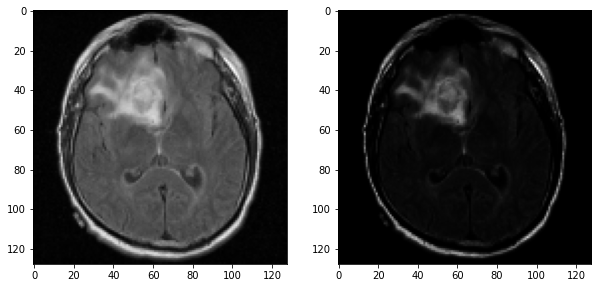

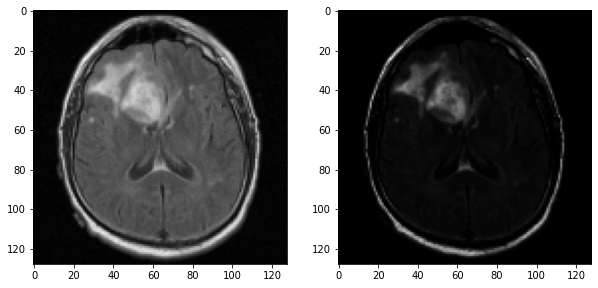

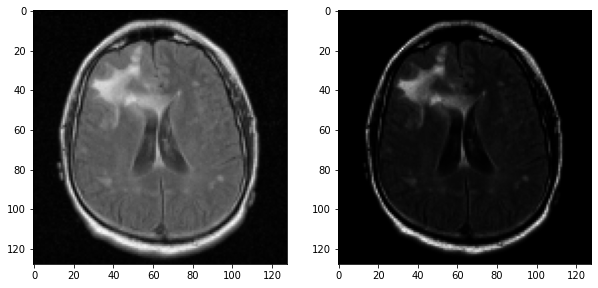

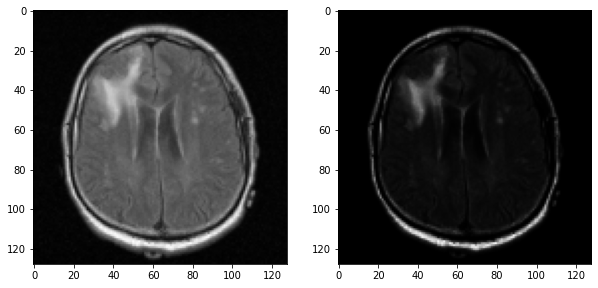

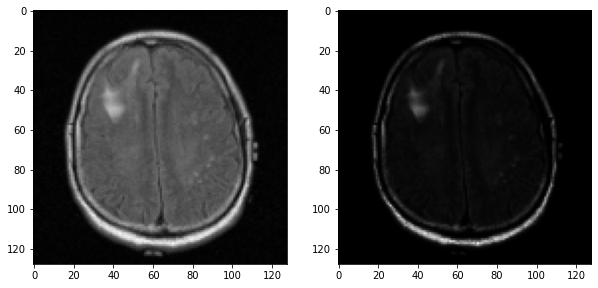

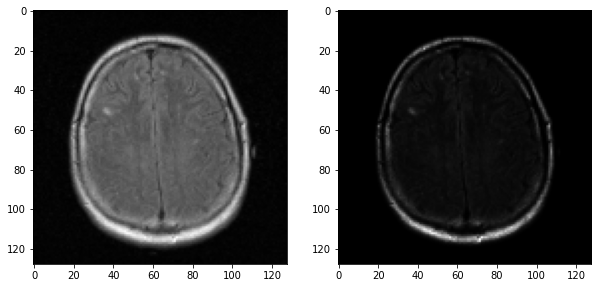

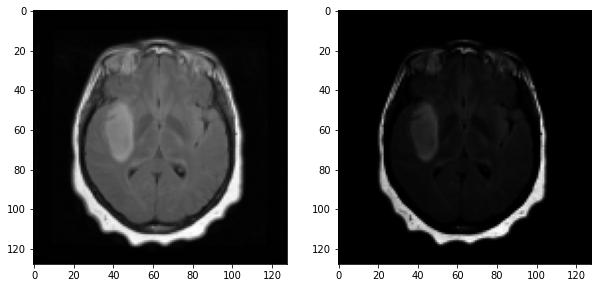

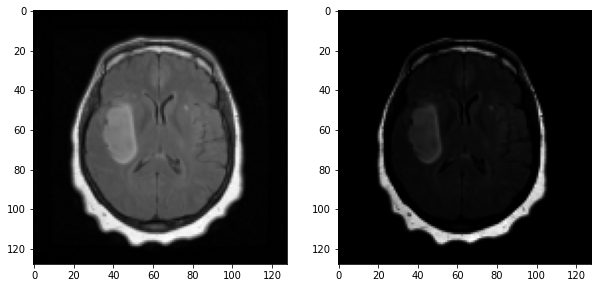

In [30]:
for i in range(0,10):
    li = LoadImaged(keys=['img','mask'])
    li_img = li(filenames[i])
    li_img['img'].shape
    add = AddChanneld(keys=['img','mask'])
    add_img = add(li_img)
    res = Resized(spatial_size  = (128,128),keys=['img'])
    res_img = res(add_img)
    res_img['img'].shape
    si = AdjustContrastd(keys=["img"],gamma=3)
    si_img = si(res_img)
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(res_img['img'][0,:,:],cmap='gray')
    ax[1].imshow(si_img['img'][0,:,:],cmap='gray')

In [31]:
org_img = Compose([
    LoadImaged(keys=['img','mask']),
    AddChanneld(keys=['img','mask']),
    Resized(spatial_size  = (128,128),keys=['img','mask']),
    AdjustContrastd(keys="img",gamma=2),
    NormalizeIntensityd(keys=['img','mask'],divisor=255.0,subtrahend=0),
    ToTensor(),
])
preprocess = Compose([
    
    LoadImaged(keys=['img','mask']),
    AddChanneld(keys=['img','mask']),
    Resized(spatial_size  = (128,128),keys=['img','mask']),
    AdjustContrastd(keys="img",gamma=2),
    NormalizeIntensityd(keys=['img','mask'],divisor=255.0,subtrahend=0),
    ToTensor(),  
    
])

In [32]:
# Preparing the DataSet
train_data = Dataset(data = filenames,transform = preprocess)

In [33]:
from torch.utils.data import random_split
val = int((len(train_data)/100)*30) # 30%
org = len(train_data)-val
print(val,org)
train_ds,val_ds = random_split(train_data,[org,val])

411 962


In [34]:
train_loder = DataLoader(train_ds,batch_size = 1)
val_loder = DataLoader(val_ds,batch_size = 1)

In [35]:
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

In [36]:
# import torch.nn.functional as F
class illumination(nn.Conv2d):
    def forward(self, input):
        return F.conv2d(input, self.weight.clamp(min=0.0, max=1.0), self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

In [37]:
device='cuda'

In [38]:
class illumination(nn.Conv2d):
    def forward(self, input):
        return F.conv2d(input, self.weight.clamp(min=0.0, max=1.0), self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

In [39]:
import warnings
from typing import Optional, Sequence, Tuple, Union

import torch
import torch.nn as nn

from monai.networks.blocks.convolutions import Convolution, ResidualUnit
from monai.networks.layers.factories import Act, Norm
from monai.networks.layers.simplelayers import SkipConnection
from monai.utils import alias, deprecated_arg, export

# __all__ = ["UNet", "Unet"]

class UNet_test(nn.Module):
    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        channels: Sequence[int],
        strides: Sequence[int],
        kernel_size: Union[Sequence[int], int] = 3,
        up_kernel_size: Union[Sequence[int], int] = 3,
        num_res_units: int = 0,
        act: Union[Tuple, str] = Act.PRELU,
        norm: Union[Tuple, str] = Norm.INSTANCE,
        dropout: float = 0.0,
        bias: bool = True,
        dimensions: Optional[int] = None,
    ) -> None:

        super().__init__()

        if len(channels) < 2:
            raise ValueError("the length of `channels` should be no less than 2.")
        delta = len(strides) - (len(channels) - 1)
        if delta < 0:
            raise ValueError("the length of `strides` should equal to `len(channels) - 1`.")
        if delta > 0:
            warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
        if dimensions is not None:
            spatial_dims = dimensions
        if isinstance(kernel_size, Sequence):
            if len(kernel_size) != spatial_dims:
                raise ValueError("the length of `kernel_size` should equal to `dimensions`.")
        if isinstance(up_kernel_size, Sequence):
            if len(up_kernel_size) != spatial_dims:
                raise ValueError("the length of `up_kernel_size` should equal to `dimensions`.")

        self.dimensions = spatial_dims
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.channels = channels
        self.strides = strides
        self.kernel_size = kernel_size
        self.up_kernel_size = up_kernel_size
        self.num_res_units = num_res_units
        self.act = act
        self.norm = norm
        self.dropout = dropout
        self.bias = bias

        def _create_block(
            inc: int, outc: int, channels: Sequence[int], strides: Sequence[int], is_top: bool
        ) -> nn.Sequential:
            c = channels[0]
            s = strides[0]

            subblock: nn.Module

            if len(channels) > 2:
                subblock = _create_block(c, c, channels[1:], strides[1:], False)  # continue recursion down
                upc = c * 2
            else:
                # the next layer is the bottom so stop recursion, create the bottom layer as the sublock for this layer
                subblock = self._get_bottom_layer(c, channels[1])
                upc = c + channels[1]

            physical_layer1 =  nn.Conv2d(inc, inc, kernel_size = (1,1), stride= (1,1), padding = 'same')  #physical layer
            # physical_layer2 =  nn.Conv2d(inc, inc, kernel_size = (3,3), stride= (1,1), padding = 'same')  #physical layer
            # physical_layer3 =  nn.Conv2d(inc, inc, kernel_size = (3,3), stride= (1,1), padding = 'same')  #physical layer

            # physical_layer =  illumination(inc, inc, kernel_size = (1,1), stride =(1,1), padding = 'same')  #physical layer
            down = self._get_down_layer(inc, c, s, is_top)  # create layer in downsampling path
            up = self._get_up_layer(upc, outc, s, is_top)  # create layer in upsampling path

            return nn.Sequential( down, 
                                  SkipConnection(subblock), 
                                  up)

        self.model =_create_block(in_channels, out_channels, self.channels, self.strides, True)

    def _get_down_layer(self, in_channels: int, out_channels: int, strides: int, is_top: bool) -> nn.Module:
        mod: nn.Module
        if self.num_res_units > 0:

            mod = ResidualUnit(
                self.dimensions,
                in_channels,
                out_channels,
                strides=strides,
                kernel_size=self.kernel_size,
                subunits=self.num_res_units,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
                bias=self.bias,
            )
            return mod
        mod = Convolution(
            self.dimensions,
            in_channels,
            out_channels,
            strides=strides,
            kernel_size=self.kernel_size,
            act=self.act,
            norm=self.norm,
            dropout=self.dropout,
            bias=self.bias,
        )
        return mod

    def _get_bottom_layer(self, in_channels: int, out_channels: int) -> nn.Module:
        return self._get_down_layer(in_channels, out_channels, 1, False)

    def _get_up_layer(self, in_channels: int, out_channels: int, strides: int, is_top: bool) -> nn.Module:
        conv: Union[Convolution, nn.Sequential]

        conv = Convolution(
            self.dimensions,
            in_channels,
            out_channels,
            strides=strides,
            kernel_size=self.up_kernel_size,
            act=self.act,
            norm=self.norm,
            dropout=self.dropout,
            bias=self.bias,
            conv_only=is_top and self.num_res_units == 0,
            is_transposed=True,
        )

        if self.num_res_units > 0:
            ru = ResidualUnit(
                self.dimensions,
                out_channels,
                out_channels,
                strides=1,
                kernel_size=self.kernel_size,
                subunits=1,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
                bias=self.bias,
                last_conv_only=is_top,
            )
            conv = nn.Sequential(conv, ru)

        return conv

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.model(x)
        return x

In [40]:
# model = monai.networks.nets.UNet(
model = UNet_test(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64,128,256,512),
        dropout=0.3,
        strides=(2, 2, 2, 2,2),
        num_res_units=3,
    ).to(device)

In [41]:
print(model)

UNet_test(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.3, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.3, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit2): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_runni

# Show output of illumination layer

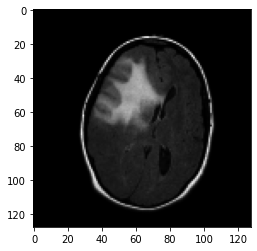

In [42]:
# for batch_data in tqdm(train_loder):
#   inputs, labels = torch.reshape(batch_data['img'],(1,1,128,128)).to(device), batch_data['mask'].to(device)
#   plt.imshow(inputs.squeeze(0).squeeze(0).cpu())

batch_sample = iter(train_loder).next()
inputs, labels = torch.reshape(batch_sample['img'],(1,1,128,128)).to(device), batch_sample['mask'].to(device)
plt.imshow(inputs.squeeze(0).squeeze(0).cpu(),cmap='gray')


In [43]:
tk = nn.Sequential(*list(model.children())[0])
# tk
tk_first = nn.Sequential(*list(tk.children()))
truncated_model = tk_first[:1]

In [44]:
truncated_model

Sequential(
  (0): ResidualUnit(
    (conv): Sequential(
      (unit0): Convolution(
        (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (adn): ADN(
          (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (D): Dropout(p=0.3, inplace=False)
          (A): PReLU(num_parameters=1)
        )
      )
      (unit1): Convolution(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (adn): ADN(
          (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (D): Dropout(p=0.3, inplace=False)
          (A): PReLU(num_parameters=1)
        )
      )
      (unit2): Convolution(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (adn): ADN(
          (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (D): Dropout(p=0.3, inplace=False)
     

In [45]:
response = truncated_model(inputs)
aa = response
response = torch.exp(response)*255
bb = response

In [46]:
response

tensor([[[[225.9797, 234.0018, 234.0018,  ..., 248.7489, 234.4278, 217.6667],
          [269.1201, 239.4458, 234.0017,  ..., 262.6003, 291.0648, 267.2498],
          [211.9927, 222.8900, 403.4352,  ..., 234.0017, 462.7020, 243.8974],
          ...,
          [223.3731, 297.7049, 450.4966,  ..., 347.0480, 234.0020, 307.2436],
          [312.6702, 234.0018, 234.0021,  ..., 234.0018, 234.0018, 229.0229],
          [417.8032, 319.4180, 350.7916,  ..., 367.4933, 461.9491, 234.0018]],

         [[277.2606, 229.4635, 347.7607,  ..., 216.6682, 337.8554, 260.6637],
          [258.7883, 229.4634, 229.4634,  ..., 407.1050, 456.9303, 454.2267],
          [295.5514, 433.0550, 347.4691,  ..., 591.8388, 229.4635, 291.4899],
          ...,
          [229.4635, 229.4634, 562.8776,  ..., 229.4634, 256.9715, 229.4637],
          [329.5768, 229.4634, 474.6302,  ..., 536.5578, 229.4636, 333.8256],
          [411.1783, 419.0973, 229.4635,  ..., 710.4422, 555.1929, 364.1862]],

         [[289.4559, 357.8561,

TypeError: ignored

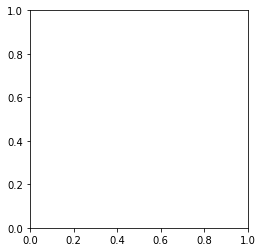

In [47]:
response = response.cpu()
plt.imshow(response.detach().squeeze(0).squeeze(0).numpy(),cmap='gray')

end show output of illumination layer

In [48]:
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [49]:
num_epochs = 200
epoch_loss_values = []
val_loss_values = []

In [ ]:
# Model Traning
for epoch in (range(num_epochs)):
        print("-" * num_epochs)
        print(f"epoch {epoch + 1}/{num_epochs}")
        model.train()
        epoch_loss = 0
        avg_val_loss = 0
        step = 0
        print('traning')
        for batch_data in tqdm(train_loder):
            step += 1
            inputs, labels = torch.reshape(batch_data['img'],(1,1,128,128)).to(device), batch_data['mask'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loder.batch_size
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        ii = 0
        for batch in tqdm(val_loder):#val_patient
            ii+=1
            inputs, labels = torch.reshape(batch['img'],(1,1,128,128)).to(device), batch['mask'].to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            avg_val_loss+=loss.item()
        avg_val_loss = avg_val_loss/ii
        val_loss_values.append(avg_val_loss)
       
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f} validation_loss: {avg_val_loss:.4f}")

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 1/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.05it/s]


epoch 1 average loss: 0.8218 validation_loss: 0.6705
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 2/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.46it/s]


epoch 2 average loss: 0.5784 validation_loss: 0.5063
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 3/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.46it/s]


epoch 3 average loss: 0.4805 validation_loss: 0.4877
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 4/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.55it/s]


epoch 4 average loss: 0.4477 validation_loss: 0.4315
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 5/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.41it/s]


epoch 5 average loss: 0.4165 validation_loss: 0.4164
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 6/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.85it/s]


epoch 6 average loss: 0.4131 validation_loss: 0.4119
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 7/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.82it/s]


epoch 7 average loss: 0.3948 validation_loss: 0.4130
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 8/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.64it/s]


epoch 8 average loss: 0.3898 validation_loss: 0.3965
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 9/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.74it/s]


epoch 9 average loss: 0.3741 validation_loss: 0.3909
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 10/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.57it/s]


epoch 10 average loss: 0.3665 validation_loss: 0.3789
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 11/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.72it/s]


epoch 11 average loss: 0.3591 validation_loss: 0.3744
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 12/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.36it/s]


epoch 12 average loss: 0.3525 validation_loss: 0.3679
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 13/200
traning


100%|██████████| 411/411 [00:07<00:00, 57.20it/s]


epoch 13 average loss: 0.3456 validation_loss: 0.3649
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 14/200
traning


100%|██████████| 411/411 [00:07<00:00, 57.36it/s]


epoch 14 average loss: 0.3433 validation_loss: 0.3478
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 15/200
traning


100%|██████████| 411/411 [00:07<00:00, 58.67it/s]


epoch 15 average loss: 0.3307 validation_loss: 0.3514
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 16/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.43it/s]


epoch 16 average loss: 0.3305 validation_loss: 0.3565
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 17/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.01it/s]


epoch 17 average loss: 0.3320 validation_loss: 0.3749
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 18/200
traning


100%|██████████| 411/411 [00:06<00:00, 58.84it/s]


epoch 18 average loss: 0.3307 validation_loss: 0.3471
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 19/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.01it/s]


epoch 19 average loss: 0.3179 validation_loss: 0.3382
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 20/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.45it/s]


epoch 20 average loss: 0.3091 validation_loss: 0.3198
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 21/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.47it/s]


epoch 21 average loss: 0.3079 validation_loss: 0.3292
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 22/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.88it/s]


epoch 22 average loss: 0.3068 validation_loss: 0.3190
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 23/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.01it/s]


epoch 23 average loss: 0.3012 validation_loss: 0.3276
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 24/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.95it/s]


epoch 24 average loss: 0.2959 validation_loss: 0.3207
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 25/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.14it/s]


epoch 25 average loss: 0.2954 validation_loss: 0.3216
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 26/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.27it/s]


epoch 26 average loss: 0.2931 validation_loss: 0.3237
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 27/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.08it/s]


epoch 27 average loss: 0.2998 validation_loss: 0.3129
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 28/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.53it/s]


epoch 28 average loss: 0.2858 validation_loss: 0.3088
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 29/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.65it/s]


epoch 29 average loss: 0.2857 validation_loss: 0.3123
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 30/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.36it/s]


epoch 30 average loss: 0.2855 validation_loss: 0.3283
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 31/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.70it/s]


epoch 31 average loss: 0.2763 validation_loss: 0.3080
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 32/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.67it/s]


epoch 32 average loss: 0.2699 validation_loss: 0.3112
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 33/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.13it/s]


epoch 33 average loss: 0.2740 validation_loss: 0.2993
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 34/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.58it/s]


epoch 34 average loss: 0.2690 validation_loss: 0.3037
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 35/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.09it/s]


epoch 35 average loss: 0.2703 validation_loss: 0.3018
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 36/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.31it/s]


epoch 36 average loss: 0.2617 validation_loss: 0.3036
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 37/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.01it/s]


epoch 37 average loss: 0.2672 validation_loss: 0.3077
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 38/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.33it/s]


epoch 38 average loss: 0.2586 validation_loss: 0.2996
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 39/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.23it/s]


epoch 39 average loss: 0.2577 validation_loss: 0.2876
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 40/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.77it/s]


epoch 40 average loss: 0.2613 validation_loss: 0.2924
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 41/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.59it/s]


epoch 41 average loss: 0.2536 validation_loss: 0.2873
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 42/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.52it/s]


epoch 42 average loss: 0.2577 validation_loss: 0.2832
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 43/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.71it/s]


epoch 43 average loss: 0.2559 validation_loss: 0.2860
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 44/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.53it/s]


epoch 44 average loss: 0.2583 validation_loss: 0.2878
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 45/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.02it/s]


epoch 45 average loss: 0.2512 validation_loss: 0.2923
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 46/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.70it/s]


epoch 46 average loss: 0.2478 validation_loss: 0.2876
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 47/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.19it/s]


epoch 47 average loss: 0.2497 validation_loss: 0.2949
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 48/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.53it/s]


epoch 48 average loss: 0.2506 validation_loss: 0.2898
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 49/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.25it/s]


epoch 49 average loss: 0.2444 validation_loss: 0.2777
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 50/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.64it/s]


epoch 50 average loss: 0.2568 validation_loss: 0.2862
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 51/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.73it/s]


epoch 51 average loss: 0.2446 validation_loss: 0.2895
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 52/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.80it/s]


epoch 52 average loss: 0.2396 validation_loss: 0.2968
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 53/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.24it/s]


epoch 53 average loss: 0.2451 validation_loss: 0.2826
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 54/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.31it/s]


epoch 54 average loss: 0.2423 validation_loss: 0.2855
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 55/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.55it/s]


epoch 55 average loss: 0.2375 validation_loss: 0.2791
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 56/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.20it/s]


epoch 56 average loss: 0.2411 validation_loss: 0.2821
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 57/200
traning


100%|██████████| 411/411 [00:07<00:00, 58.40it/s]


epoch 57 average loss: 0.2327 validation_loss: 0.2801
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 58/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.00it/s]


epoch 58 average loss: 0.2337 validation_loss: 0.2828
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 59/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.98it/s]


epoch 59 average loss: 0.2326 validation_loss: 0.2804
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 60/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.85it/s]


epoch 60 average loss: 0.2290 validation_loss: 0.2729
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 61/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.46it/s]


epoch 61 average loss: 0.2276 validation_loss: 0.2998
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 62/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.72it/s]


epoch 62 average loss: 0.2294 validation_loss: 0.2840
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 63/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.22it/s]


epoch 63 average loss: 0.2292 validation_loss: 0.2744
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 64/200
traning


100%|██████████| 411/411 [00:07<00:00, 57.35it/s]


epoch 64 average loss: 0.2252 validation_loss: 0.2682
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 65/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.19it/s]


epoch 65 average loss: 0.2293 validation_loss: 0.2778
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 66/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.33it/s]


epoch 66 average loss: 0.2246 validation_loss: 0.2770
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 67/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.20it/s]


epoch 67 average loss: 0.2270 validation_loss: 0.2931
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 68/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.17it/s]


epoch 68 average loss: 0.2297 validation_loss: 0.2719
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 69/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.80it/s]


epoch 69 average loss: 0.2240 validation_loss: 0.2701
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 70/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.85it/s]


epoch 70 average loss: 0.2268 validation_loss: 0.2686
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 71/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.02it/s]


epoch 71 average loss: 0.2215 validation_loss: 0.2821
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 72/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.07it/s]


epoch 72 average loss: 0.2242 validation_loss: 0.2712
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 73/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.69it/s]


epoch 73 average loss: 0.2271 validation_loss: 0.2968
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 74/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.56it/s]


epoch 74 average loss: 0.2158 validation_loss: 0.2773
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 75/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.84it/s]


epoch 75 average loss: 0.2202 validation_loss: 0.2675
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 76/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.69it/s]


epoch 76 average loss: 0.2169 validation_loss: 0.2673
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 77/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.93it/s]


epoch 77 average loss: 0.2129 validation_loss: 0.2751
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 78/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.71it/s]


epoch 78 average loss: 0.2182 validation_loss: 0.2647
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 79/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.95it/s]


epoch 79 average loss: 0.2163 validation_loss: 0.2831
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 80/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.26it/s]


epoch 80 average loss: 0.2124 validation_loss: 0.2744
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 81/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.49it/s]


epoch 81 average loss: 0.2111 validation_loss: 0.2820
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 82/200
traning


100%|██████████| 411/411 [00:06<00:00, 62.25it/s]


epoch 82 average loss: 0.2249 validation_loss: 0.2691
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 83/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.18it/s]


epoch 83 average loss: 0.2136 validation_loss: 0.2800
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 84/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.80it/s]


epoch 84 average loss: 0.2183 validation_loss: 0.2669
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 85/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.29it/s]


epoch 85 average loss: 0.2178 validation_loss: 0.2802
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 86/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.89it/s]


epoch 86 average loss: 0.2178 validation_loss: 0.2640
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 87/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.39it/s]


epoch 87 average loss: 0.2112 validation_loss: 0.2668
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 88/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.23it/s]


epoch 88 average loss: 0.2156 validation_loss: 0.2701
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 89/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.15it/s]


epoch 89 average loss: 0.2086 validation_loss: 0.2625
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 90/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.54it/s]


epoch 90 average loss: 0.2088 validation_loss: 0.2676
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 91/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.12it/s]


epoch 91 average loss: 0.2066 validation_loss: 0.2559
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 92/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.93it/s]


epoch 92 average loss: 0.2060 validation_loss: 0.2705
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 93/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.33it/s]


epoch 93 average loss: 0.2118 validation_loss: 0.2677
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 94/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.32it/s]


epoch 94 average loss: 0.2040 validation_loss: 0.2603
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 95/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.89it/s]


epoch 95 average loss: 0.2070 validation_loss: 0.2772
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 96/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.74it/s]


epoch 96 average loss: 0.2050 validation_loss: 0.2723
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 97/200
traning


100%|██████████| 411/411 [00:06<00:00, 62.07it/s]


epoch 97 average loss: 0.2006 validation_loss: 0.2601
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 98/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.88it/s]


epoch 98 average loss: 0.2053 validation_loss: 0.2670
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 99/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.87it/s]


epoch 99 average loss: 0.2111 validation_loss: 0.2690
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 100/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.69it/s]


epoch 100 average loss: 0.2021 validation_loss: 0.2577
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 101/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.91it/s]


epoch 101 average loss: 0.2020 validation_loss: 0.2589
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 102/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.68it/s]


epoch 102 average loss: 0.2044 validation_loss: 0.2719
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 103/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.71it/s]


epoch 103 average loss: 0.1965 validation_loss: 0.2542
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 104/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.40it/s]


epoch 104 average loss: 0.2033 validation_loss: 0.2575
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 105/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.02it/s]


epoch 105 average loss: 0.2029 validation_loss: 0.2678
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 106/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.27it/s]


epoch 106 average loss: 0.2069 validation_loss: 0.2669
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 107/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.13it/s]


epoch 107 average loss: 0.2028 validation_loss: 0.2672
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 108/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.80it/s]


epoch 108 average loss: 0.2005 validation_loss: 0.2652
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 109/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.91it/s]


epoch 109 average loss: 0.2007 validation_loss: 0.2712
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 110/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.82it/s]


epoch 110 average loss: 0.1957 validation_loss: 0.2623
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 111/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.06it/s]


epoch 111 average loss: 0.1961 validation_loss: 0.2580
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 112/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.22it/s]


epoch 112 average loss: 0.1992 validation_loss: 0.2643
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 113/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.94it/s]


epoch 113 average loss: 0.1993 validation_loss: 0.2568
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 114/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.42it/s]


epoch 114 average loss: 0.2014 validation_loss: 0.2869
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 115/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.69it/s]


epoch 115 average loss: 0.1950 validation_loss: 0.2538
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 116/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.86it/s]


epoch 116 average loss: 0.1979 validation_loss: 0.2688
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 117/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.27it/s]


epoch 117 average loss: 0.1942 validation_loss: 0.2635
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 118/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.11it/s]


epoch 118 average loss: 0.1951 validation_loss: 0.2572
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 119/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.27it/s]


epoch 119 average loss: 0.1933 validation_loss: 0.2641
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 120/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.98it/s]


epoch 120 average loss: 0.1934 validation_loss: 0.2695
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 121/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.75it/s]


epoch 121 average loss: 0.1988 validation_loss: 0.2670
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 122/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.37it/s]


epoch 122 average loss: 0.1950 validation_loss: 0.2543
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 123/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.97it/s]


epoch 123 average loss: 0.1938 validation_loss: 0.2589
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 124/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.61it/s]


epoch 124 average loss: 0.1918 validation_loss: 0.2812
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 125/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.37it/s]


epoch 125 average loss: 0.1942 validation_loss: 0.2612
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 126/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.69it/s]


epoch 126 average loss: 0.1933 validation_loss: 0.2624
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 127/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.68it/s]


epoch 127 average loss: 0.1956 validation_loss: 0.2648
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 128/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.47it/s]


epoch 128 average loss: 0.1908 validation_loss: 0.2600
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 129/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.00it/s]


epoch 129 average loss: 0.1951 validation_loss: 0.2619
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 130/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.24it/s]


epoch 130 average loss: 0.1907 validation_loss: 0.2623
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 131/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.07it/s]


epoch 131 average loss: 0.1915 validation_loss: 0.2588
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 132/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.64it/s]


epoch 132 average loss: 0.1950 validation_loss: 0.2713
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 133/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.78it/s]


epoch 133 average loss: 0.1867 validation_loss: 0.2624
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 134/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.83it/s]


epoch 134 average loss: 0.1847 validation_loss: 0.2469
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 135/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.00it/s]


epoch 135 average loss: 0.1923 validation_loss: 0.2574
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 136/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.74it/s]


epoch 136 average loss: 0.1864 validation_loss: 0.2697
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 137/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.56it/s]


epoch 137 average loss: 0.1859 validation_loss: 0.2670
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 138/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.08it/s]


epoch 138 average loss: 0.1897 validation_loss: 0.2558
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 139/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.31it/s]


epoch 139 average loss: 0.1897 validation_loss: 0.2556
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 140/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.80it/s]


epoch 140 average loss: 0.1879 validation_loss: 0.2545
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 141/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.13it/s]


epoch 141 average loss: 0.1893 validation_loss: 0.2610
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 142/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.51it/s]


epoch 142 average loss: 0.1884 validation_loss: 0.2538
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 143/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.81it/s]


epoch 143 average loss: 0.1882 validation_loss: 0.2465
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 144/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.19it/s]


epoch 144 average loss: 0.1889 validation_loss: 0.2567
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 145/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.67it/s]


epoch 145 average loss: 0.1877 validation_loss: 0.2478
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 146/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.26it/s]


epoch 146 average loss: 0.1829 validation_loss: 0.2667
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 147/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.46it/s]


epoch 147 average loss: 0.1861 validation_loss: 0.2650
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 148/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.86it/s]


epoch 148 average loss: 0.1875 validation_loss: 0.2614
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 149/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.95it/s]


epoch 149 average loss: 0.1863 validation_loss: 0.2504
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 150/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.68it/s]


epoch 150 average loss: 0.1825 validation_loss: 0.2587
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 151/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.76it/s]


epoch 151 average loss: 0.1861 validation_loss: 0.2638
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 152/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.24it/s]


epoch 152 average loss: 0.1893 validation_loss: 0.2443
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 153/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.95it/s]


epoch 153 average loss: 0.1785 validation_loss: 0.2558
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 154/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.10it/s]


epoch 154 average loss: 0.1796 validation_loss: 0.2473
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 155/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.18it/s]


epoch 155 average loss: 0.1827 validation_loss: 0.2572
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 156/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.22it/s]


epoch 156 average loss: 0.1854 validation_loss: 0.2611
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 157/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.78it/s]


epoch 157 average loss: 0.1833 validation_loss: 0.2544
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 158/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.61it/s]


epoch 158 average loss: 0.1778 validation_loss: 0.2473
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 159/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.59it/s]


epoch 159 average loss: 0.1801 validation_loss: 0.2434
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 160/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.41it/s]


epoch 160 average loss: 0.1828 validation_loss: 0.2486
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 161/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.45it/s]


epoch 161 average loss: 0.1811 validation_loss: 0.2691
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 162/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.46it/s]


epoch 162 average loss: 0.1819 validation_loss: 0.2477
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 163/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.99it/s]


epoch 163 average loss: 0.1808 validation_loss: 0.2889
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 164/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.34it/s]


epoch 164 average loss: 0.1808 validation_loss: 0.2671
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 165/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.85it/s]


epoch 165 average loss: 0.1833 validation_loss: 0.2546
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 166/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.56it/s]


epoch 166 average loss: 0.1803 validation_loss: 0.2543
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 167/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.48it/s]


epoch 167 average loss: 0.1789 validation_loss: 0.2543
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 168/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.20it/s]


epoch 168 average loss: 0.1776 validation_loss: 0.2579
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 169/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.32it/s]


epoch 169 average loss: 0.1798 validation_loss: 0.2567
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 170/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.00it/s]


epoch 170 average loss: 0.1788 validation_loss: 0.2450
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 171/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.96it/s]


epoch 171 average loss: 0.1790 validation_loss: 0.2553
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 172/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.85it/s]


epoch 172 average loss: 0.1770 validation_loss: 0.2673
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 173/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.86it/s]


epoch 173 average loss: 0.1774 validation_loss: 0.2943
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 174/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.03it/s]


epoch 174 average loss: 0.1798 validation_loss: 0.2519
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 175/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.41it/s]


epoch 175 average loss: 0.1782 validation_loss: 0.2739
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 176/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.99it/s]


epoch 176 average loss: 0.1787 validation_loss: 0.2528
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 177/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.32it/s]


epoch 177 average loss: 0.1768 validation_loss: 0.2439
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 178/200
traning


100%|██████████| 411/411 [00:07<00:00, 58.16it/s]


epoch 178 average loss: 0.1761 validation_loss: 0.2489
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 179/200
traning


100%|██████████| 411/411 [00:06<00:00, 58.94it/s]


epoch 179 average loss: 0.1779 validation_loss: 0.2569
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 180/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.33it/s]


epoch 180 average loss: 0.1803 validation_loss: 0.2690
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 181/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.60it/s]


epoch 181 average loss: 0.1788 validation_loss: 0.2469
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 182/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.12it/s]


epoch 182 average loss: 0.1797 validation_loss: 0.2449
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 183/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.68it/s]


epoch 183 average loss: 0.1737 validation_loss: 0.2622
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 184/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.93it/s]


epoch 184 average loss: 0.1772 validation_loss: 0.2570
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 185/200
traning


100%|██████████| 411/411 [00:06<00:00, 61.40it/s]


epoch 185 average loss: 0.1788 validation_loss: 0.2735
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 186/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.32it/s]


epoch 186 average loss: 0.1797 validation_loss: 0.2560
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 187/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.52it/s]


epoch 187 average loss: 0.1748 validation_loss: 0.2523
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 188/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.59it/s]


epoch 188 average loss: 0.1759 validation_loss: 0.2557
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 189/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.64it/s]


epoch 189 average loss: 0.1719 validation_loss: 0.2609
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 190/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.46it/s]


epoch 190 average loss: 0.1733 validation_loss: 0.2666
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 191/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.37it/s]


epoch 191 average loss: 0.1777 validation_loss: 0.2607
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 192/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.49it/s]


epoch 192 average loss: 0.1764 validation_loss: 0.2552
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 193/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.82it/s]


epoch 193 average loss: 0.1752 validation_loss: 0.2584
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 194/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.35it/s]


epoch 194 average loss: 0.1747 validation_loss: 0.2557
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 195/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.69it/s]


epoch 195 average loss: 0.1757 validation_loss: 0.2653
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 196/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.48it/s]


epoch 196 average loss: 0.1766 validation_loss: 0.2559
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 197/200
traning


100%|██████████| 411/411 [00:06<00:00, 59.97it/s]


epoch 197 average loss: 0.1694 validation_loss: 0.2557
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 198/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.91it/s]


epoch 198 average loss: 0.1713 validation_loss: 0.2486
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 199/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.23it/s]


epoch 199 average loss: 0.1724 validation_loss: 0.2501
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 200/200
traning


100%|██████████| 411/411 [00:06<00:00, 60.80it/s]

epoch 200 average loss: 0.1736 validation_loss: 0.2468


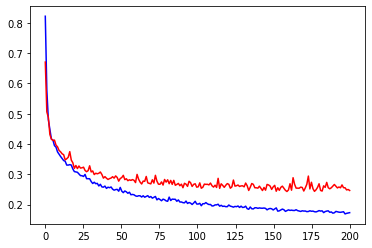

In [ ]:
plt.plot(np.linspace(0,len(epoch_loss_values),len(epoch_loss_values)),epoch_loss_values,color='blue')
plt.plot(np.linspace(0,len(val_loss_values),len(val_loss_values)),val_loss_values,color='red')

In [ ]:
# r = 10
# i=0
# fig,ax = plt.subplots(r,3,figsize=(20,40))
# for batch in val_loder:
#     inp = torch.reshape(batch['img'],(1,1,128,128)).to(device)
#     out = model(inp).to('cpu')
#     ax[i,0].imshow(batch['img'][0,0,:,:],cmap='gray')
#     ax[i,0].title.set_text('MRI')
#     ax[i,1].imshow(batch['mask'][0,0,:,:],cmap='gray')
#     ax[i,1].title.set_text('Mask')
#     # ax[i,2].imshow(out[0,0,:,:].detach().numpy().astype('uint8'),cmap='gray')
#     output = out[0,0,:,:].detach().numpy().astype('uint8')
#     for w in range(128):
#       for h in range(128):
#         if output[w,h] > 150:
#           output[w,h] = 0
#         else:
#           output[w,h] =1    
#     ax[i,2].imshow(output,cmap='gray')
#     # ax[i,2].imshow(out[0,0,:,:].detach().numpy().astype('uint8'),cmap='binary')
#     ax[i,2].title.set_text('Predicted Mask')
#     if i>=r-1:
#         break
#     i=i+1

# print(batch['mask'][0,0,:,:])
# for i in range(128):
#   print(batch['mask'][0,0,i,:].detach().numpy().astype('uint8'))
#   print(out[0,0,i,:].detach().numpy().astype('uint8'))


#for samples draw
# r = 10
# i=0
# ave_tp =0
# fig,ax = plt.subplots(r,3,figsize=(20,40))
# for batch in val_loder:
#     tp =0
#     mask = batch['mask'][0,0,:,:].detach().numpy().astype('uint8')
#     inp = torch.reshape(batch['img'],(1,1,128,128)).to(device)
#     out = model(inp).to('cpu')
#     ax[i,0].imshow(batch['img'][0,0,:,:],cmap='gray')
#     ax[i,0].title.set_text('MRI')
#     ax[i,1].imshow(batch['mask'][0,0,:,:],cmap='gray')
#     ax[i,1].title.set_text('Mask')
#     # ax[i,2].imshow(out[0,0,:,:].detach().numpy().astype('uint8'),cmap='gray')
#     output = out[0,0,:,:].detach().numpy().astype('uint8')
#     for w in range(128):
#       for h in range(128):
#         if output[w,h] > 150:   #150
#           output[w,h] = 0
#         else:
#           output[w,h] =1  
#         if mask[w,h] == output[w,h]:
#           tp += 1
#     print("image",i," pixel accuracy=",tp/(128*128))
#     ave_tp += tp/(128*128)
#     ax[i,2].imshow(output,cmap='gray')
#     # # ax[i,2].imshow(out[0,0,:,:].detach().numpy().astype('uint8'),cmap='binary')
#     ax[i,2].title.set_text('Predicted Mask' + str(tp/(128*128)))
#     if i>=r-1:
#         break
#     i=i+1  

# print(ave_tp/r)


# for compute average pixel accuracy with weight
r = 10
i=0
ave_tp =0
# fig,ax = plt.subplots(r,3,figsize=(20,40))
for batch in val_loder:
    tp =0
    leision_size = 0
    mask = batch['mask'][0,0,:,:].detach().numpy().astype('uint8')
    inp = torch.reshape(batch['img'],(1,1,128,128)).to(device)
    out = model(inp).to('cpu')
    # ax[i,0].imshow(batch['img'][0,0,:,:],cmap='gray')
    # ax[i,0].title.set_text('MRI')
    # ax[i,1].imshow(batch['mask'][0,0,:,:],cmap='gray')
    # ax[i,1].title.set_text('Mask')
    # ax[i,2].imshow(out[0,0,:,:].detach().numpy().astype('uint8'),cmap='gray')
    output = out[0,0,:,:].detach().numpy().astype('uint8')
    for w in range(128):
      for h in range(128):
        if output[w,h] > 150:   #150
          output[w,h] = 0
        else:
          output[w,h] =1  
        if mask[w,h] == output[w,h]:
          tp += 1
        if output[w,h] == 1:
          leision_size += 1
    print("image",i," pixel accuracy=",tp/(128*128)," pixel_accuracy_with_weight=",(tp*466/leision_size)/(128*128))
    ave_tp += (tp*466/leision_size)/(128*128)
    # ax[i,2].imshow(output,cmap='gray')
    # # ax[i,2].imshow(out[0,0,:,:].detach().numpy().astype('uint8'),cmap='binary')
    # ax[i,2].title.set_text('Predicted Mask' + str(tp/(128*128)))
    # if i>=r-1:
    #     break
    i=i+1  

print(ave_tp/i)


#for compute average leision size
#1: whith 0:black
#average leision size: 466 pixel
# r = 10
# i=0
# ave_tp =0
# # fig,ax = plt.subplots(r,3,figsize=(20,40))
# for batch in val_loder:
#     tp =0
#     mask = batch['mask'][0,0,:,:].detach().numpy().astype('uint8')
#     for w in range(128):
#       for h in range(128): 
#         if mask[w,h] == 1:
#           tp += 1
#     # print(tp)
#     ave_tp += tp
#     i=i+1
# ave_tp = ave_tp/i
# print(ave_tp)